<a href="https://colab.research.google.com/github/ViniciusRodriguesAdm/Dataset-Para-Modelagem-de-Dados/blob/main/Dataset_Para_Modelagem_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sidetable
!pip install pandas-profiling==3.3.0
!pip install --upgrade matplotlib
!pip install xlrd -q
!pip install openpyxl -q
!pip install lifetimes -q

In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import missingno as msno
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler
from lifetimes.plotting import plot_period_transactions
from sklearn import metrics
import warnings
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder, OrdinalEncoder

In [ ]:
#Baixando o arquivo para o desafio
ec = pd.read_csv("data.csv", encoding="latin1")
ec.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
#Renomeando as colunas
ec = ec.rename(columns={"InvoiceNo": "Código da fatura","StockCode": "Código de estoque do produto","Description": "Descrição do produto","Quantity": "Quantidade do produto","InvoiceDate": "Data do faturamento (compra)","UnitPrice": "Preço unitário do produto","CustomerID": "Código de identificação do cliente","Country": "País da compra"})
ec.head()

,Código da fatura,Código de estoque do produto,Descrição do produto,Quantidade do produto,Data do faturamento (compra),Preço unitário do produto,Código de identificação do cliente,País da compra
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
#Entendendo os dados
ec.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#Analisando dos dados (nulos e não nulos) e o tipo de dados
ec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12462 entries, 0 to 12461
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Código da fatura                    12462 non-null  object 
 1   Código de estoque do produto        12462 non-null  object 
 2   Descrição do produto                12417 non-null  object 
 3   Quantidade do produto               12461 non-null  float64
 4   Data do faturamento (compra)        12461 non-null  object 
 5   Preço unitário do produto           12461 non-null  float64
 6   Código de identificação do cliente  8956 non-null   float64
 7   País da compra                      12461 non-null  object 
dtypes: float64(3), object(5)
memory usage: 779.0+ KB


In [ ]:
#Identificando e mostrar valores nulos
ec_missing = (
  ec.isna().sum()
  .to_frame('missing_count')
  .join((ec.isna().sum() / ec.shape[0]).to_frame('missing_pct'))
  .sort_values('missing_count', ascending=False)
)

ec_missing.style.format('{:.2%}', subset=['missing_pct'])

,missing_count,missing_pct
Código de identificação do cliente,3506,28.13%
Descrição do produto,45,0.36%
Quantidade do produto,1,0.01%
Data do faturamento (compra),1,0.01%
Preço unitário do produto,1,0.01%
País da compra,1,0.01%
Código da fatura,0,0.00%
Código de estoque do produto,0,0.00%


In [ ]:
#Mostrando as linhas com valores faltantes como um todo:
ec[ec.isna().any(axis=1)]

,Código da fatura,Código de estoque do produto,Descrição do produto,Quantidade do produto,Data do faturamento (compra),Preço unitário do produto,Código de identificação do cliente,País da compra
622,536414,22139,NaN,56.0,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1.0,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2.0,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4.0,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2.0,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
11546,537253,22429,ENAMEL MEASURING JUG CREAM,3.0,12/6/2010 10:53,4.25,NaN,United Kingdom
12008,537361,21777,NaN,5.0,12/6/2010 12:34,0.00,NaN,United Kingdom
12069,537363,84569B,NaN,-20.0,12/6/2010 12:35,0.00,NaN,United Kingdom
12070,537364,21027,NaN,-70.0,12/6/2010 12:36,0.00,NaN,United Kingdom


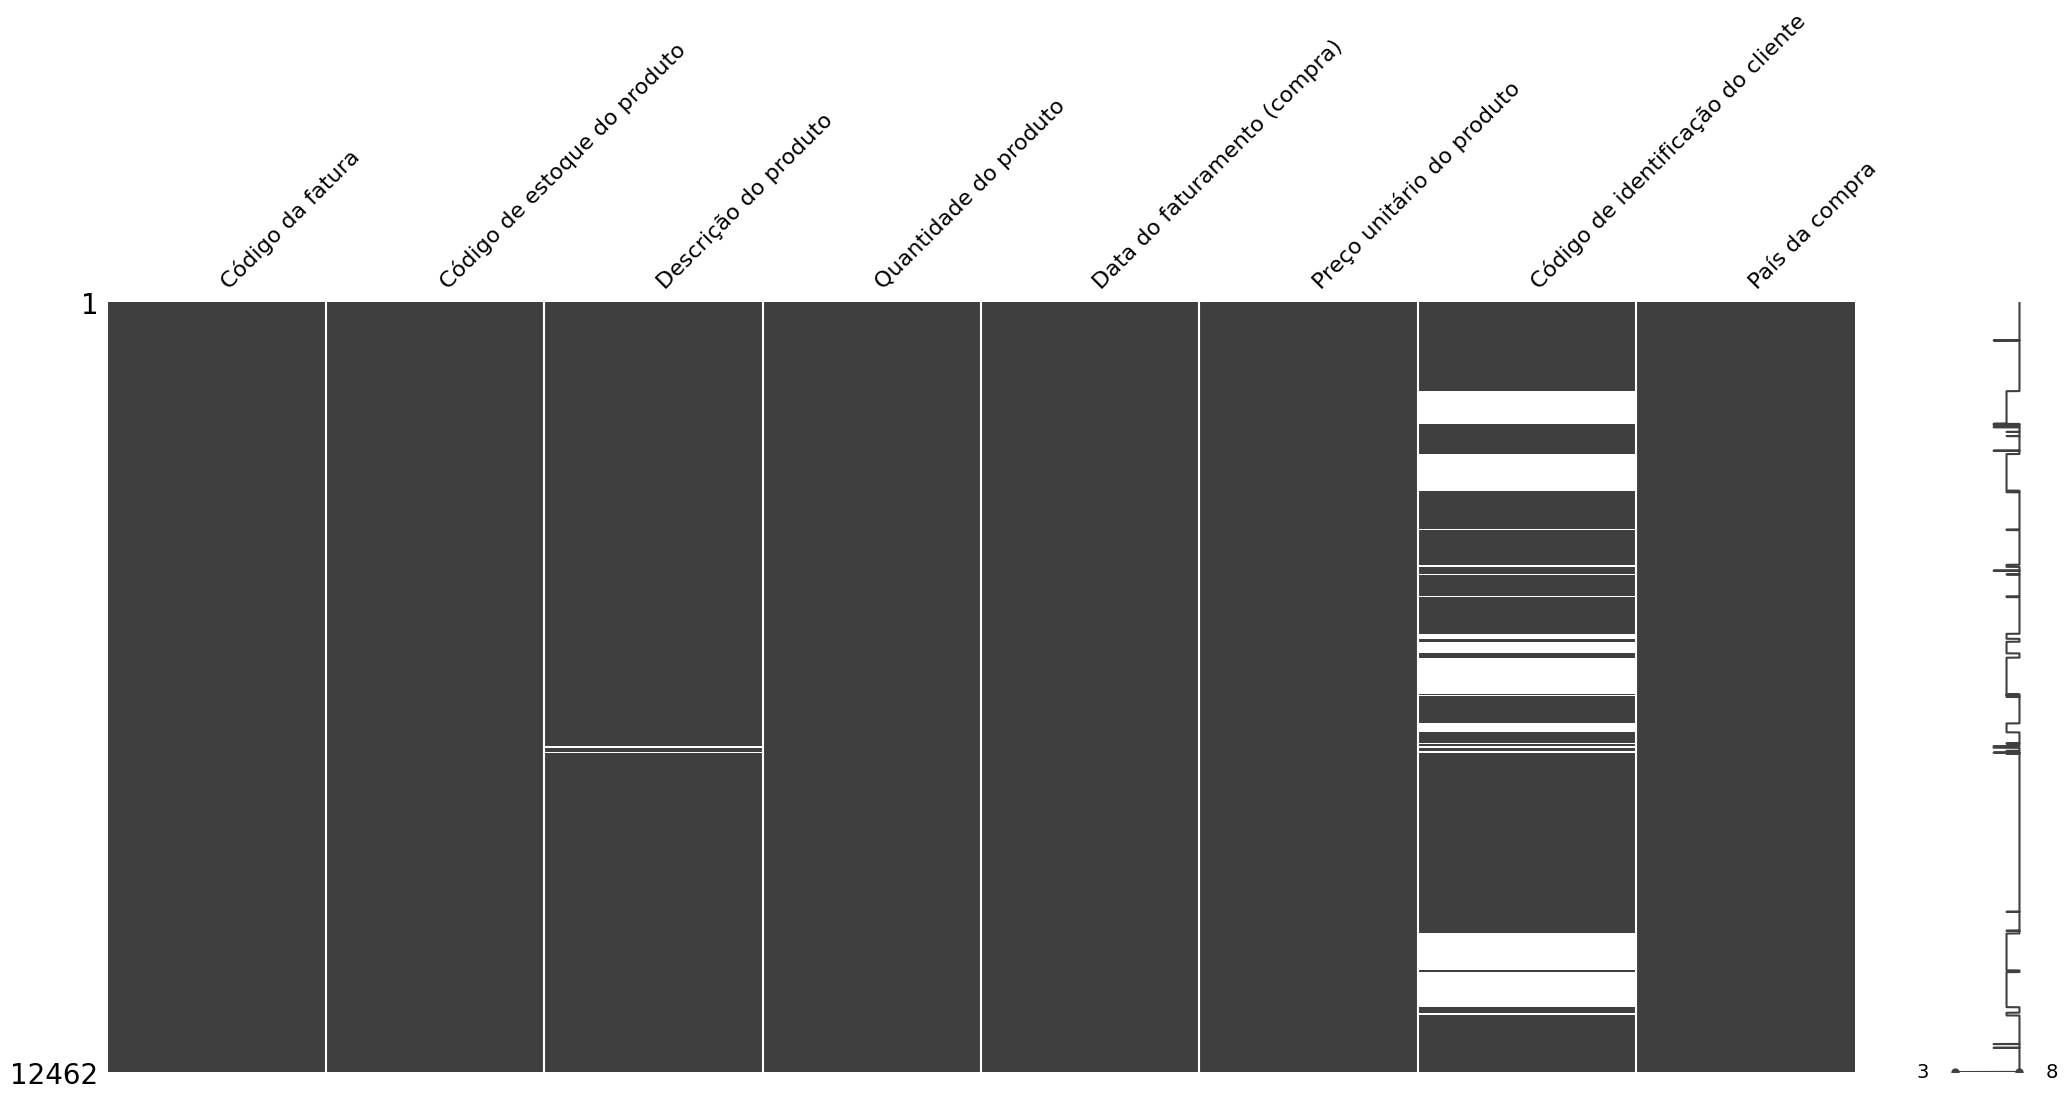

In [ ]:
#Utilizando a biblioteca missgno:
msno.matrix(ec);

In [ ]:
#Mostrando as linhas com valores faltantes como um todo:
ec[ec.isna().any(axis=1)]

,Código da fatura,Código de estoque do produto,Descrição do produto,Quantidade do produto,Data do faturamento (compra),Preço unitário do produto,Código de identificação do cliente,País da compra
622,536414,22139,NaN,56.0,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1.0,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2.0,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4.0,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2.0,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
11546,537253,22429,ENAMEL MEASURING JUG CREAM,3.0,12/6/2010 10:53,4.25,NaN,United Kingdom
12008,537361,21777,NaN,5.0,12/6/2010 12:34,0.00,NaN,United Kingdom
12069,537363,84569B,NaN,-20.0,12/6/2010 12:35,0.00,NaN,United Kingdom
12070,537364,21027,NaN,-70.0,12/6/2010 12:36,0.00,NaN,United Kingdom


In [ ]:
#Removendo os nulos nas colunas Código de identificação do cliente e Descrição do produto
ec.drop(columns=['Código de identificação do cliente'])
ec.drop(columns=['Descrição do produto'])

,Código da fatura,Código de estoque do produto,Quantidade do produto,Data do faturamento (compra),Preço unitário do produto,Código de identificação do cliente,País da compra
0,536365,85123A,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
12457,537381,22632,24.0,12/6/2010 13:13,2.10,14667.0,United Kingdom
12458,537381,22633,20.0,12/6/2010 13:13,2.10,14667.0,United Kingdom
12459,537381,22867,24.0,12/6/2010 13:13,2.10,14667.0,United Kingdom
12460,537381,22601,17.0,12/6/2010 13:13,0.85,14667.0,United Kingdom


In [ ]:
#Removendo os preços unitários iguais ou inferior a zero das colunas Preço unitário do produto e Quantidade do produto
ec = ec[ec['Preço unitário do produto'] > 0]
ec = ec[ec['Quantidade do produto'] > 0]
ec.head()

,Código da fatura,Código de estoque do produto,Descrição do produto,Quantidade do produto,Data do faturamento (compra),Preço unitário do produto,Código de identificação do cliente,País da compra
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
#Identificando valores duplicados
ec[ec.duplicated(keep=False)]

,Código da fatura,Código de estoque do produto,Descrição do produto,Quantidade do produto,Data do faturamento (compra),Preço unitário do produto,Código de identificação do cliente,País da compra
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1.0,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1.0,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1.0,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
12310,537374,79051A,SMOKEY GREY COLOUR D.O.F. GLASS,4.0,12/6/2010 12:55,0.65,17259.0,United Kingdom
12323,537374,22974,CHILDRENS DOLLY GIRL MUG,1.0,12/6/2010 12:55,1.65,17259.0,United Kingdom
12327,537374,21738,COSY SLIPPER SHOES SMALL RED,1.0,12/6/2010 12:55,2.95,17259.0,United Kingdom
12338,537374,22549,PICTURE DOMINOES,1.0,12/6/2010 12:55,1.45,17259.0,United Kingdom


In [ ]:
# Identificando quantos valores duplicados há em cada duplicata
(
  ec
 .groupby(ec.columns.tolist(), dropna=False)
 .size()
 .to_frame('n_duplicates')
 .query('n_duplicates>1')
 .sort_values('n_duplicates', ascending=False)
 .head(5)
)

,,,,,,,,n_duplicates
Código da fatura,Código de estoque do produto,Descrição do produto,Quantidade do produto,Data do faturamento (compra),Preço unitário do produto,Código de identificação do cliente,País da compra,
537224,70007,HI TEC ALPINE HAND WARMER,1.0,12/5/2010 16:24,1.65,13174.0,United Kingdom,5
536874,22866,HAND WARMER SCOTTY DOG DESIGN,1.0,12/3/2010 11:35,2.10,16891.0,United Kingdom,3
536749,22174,PHOTO CUBE,2.0,12/2/2010 13:49,1.65,17976.0,United Kingdom,3
537224,22086,PAPER CHAIN KIT 50'S CHRISTMAS,1.0,12/5/2010 16:24,2.95,13174.0,United Kingdom,3
536796,21967,PACK OF 12 SKULL TISSUES,1.0,12/2/2010 15:46,0.29,15574.0,United Kingdom,3


In [ ]:
# Removendo valores duplicados
ec.drop_duplicates()

,Código da fatura,Código de estoque do produto,Descrição do produto,Quantidade do produto,Data do faturamento (compra),Preço unitário do produto,Código de identificação do cliente,País da compra
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
12456,537381,22865,HAND WARMER OWL DESIGN,10.0,12/6/2010 13:13,2.10,14667.0,United Kingdom
12457,537381,22632,HAND WARMER RED RETROSPOT,24.0,12/6/2010 13:13,2.10,14667.0,United Kingdom
12458,537381,22633,HAND WARMER UNION JACK,20.0,12/6/2010 13:13,2.10,14667.0,United Kingdom
12459,537381,22867,HAND WARMER BIRD DESIGN,24.0,12/6/2010 13:13,2.10,14667.0,United Kingdom


In [ ]:
ec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12285 entries, 0 to 12460
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Código da fatura                    12285 non-null  object 
 1   Código de estoque do produto        12285 non-null  object 
 2   Descrição do produto                12285 non-null  object 
 3   Quantidade do produto               12285 non-null  float64
 4   Data do faturamento (compra)        12285 non-null  object 
 5   Preço unitário do produto           12285 non-null  float64
 6   Código de identificação do cliente  8848 non-null   float64
 7   País da compra                      12285 non-null  object 
dtypes: float64(3), object(5)
memory usage: 863.8+ KB


In [ ]:
#Formatando os tipos de dados das colunas Data do faturamento (compra) e Código de identificação do cliente
ec['Código de identificação do cliente'] = ec['Código de identificação do cliente'].dropna().astype('int64')
ec['Data do faturamento (compra)'] = ec['Data do faturamento (compra)'].astype('datetime64[ns]')

In [ ]:
#Tratamento de outliers
ec = ec[ec['Quantidade do produto'] <= 10000]
ec = ec[ec['Preço unitário do produto'] <= 5000]

In [ ]:
#Criando a coluna preço total da compra
ec['Preço total da compra'] = ec['Quantidade do produto'] * ec['Preço unitário do produto']
ec.head()

,Código da fatura,Código de estoque do produto,Descrição do produto,Quantidade do produto,Data do faturamento (compra),Preço unitário do produto,Código de identificação do cliente,País da compra,Preço total da compra
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
#Calculando a data da última compra no dataset
DataUltimaCompra = ec['Data do faturamento (compra)'].max()
DataUltimaCompra

Timestamp('2010-12-06 13:13:00')

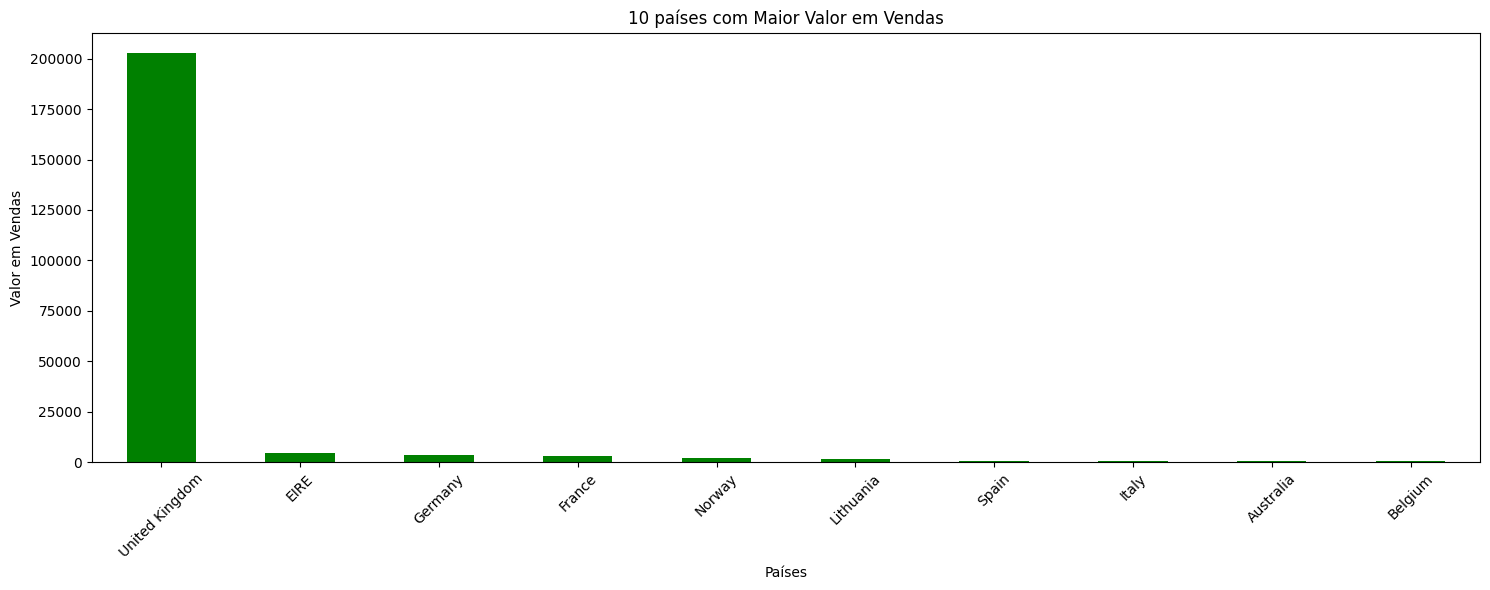

In [ ]:
#Gráfico com os 10 países com maior valor em vendas

venda_por_pais = ec.groupby('País da compra')['Preço total da compra'].sum()
top_10_vendas_pais = venda_por_pais.sort_values(ascending=False).head(10)
plt.figure(figsize=(15, 6))
top_10_vendas_pais.plot(kind="bar", color="green")
plt.title("10 países com Maior Valor em Vendas")
plt.xlabel("Países")
plt.ylabel("Valor em Vendas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

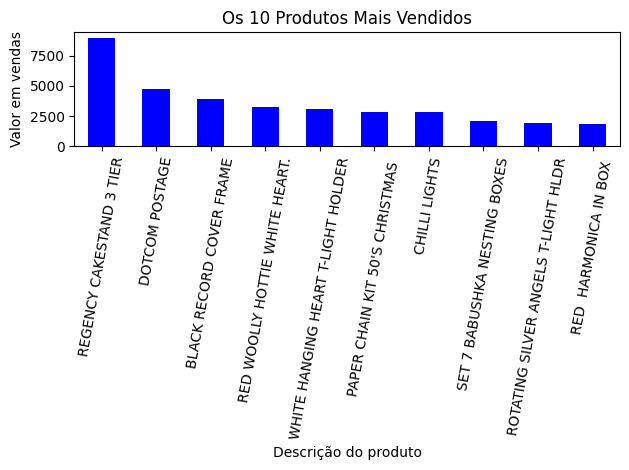

In [ ]:
#Gráfico com os 10 produtos mais vendidos

top_10_products = ec.groupby('Descrição do produto')['Preço total da compra'].sum().nlargest(10)
top_10_products.plot(kind='bar', color='blue')
plt.xlabel('Descrição do produto')
plt.ylabel('Valor em vendas')
plt.title('Os 10 Produtos Mais Vendidos')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

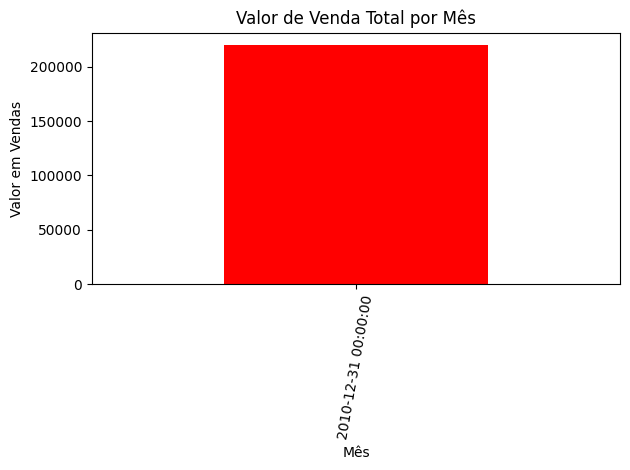

In [ ]:
#Gráfico com Valor de venda total por mês

venda_total = ec.groupby(pd.Grouper(key='Data do faturamento (compra)', freq='M'))['Preço total da compra'].sum().nlargest(10)
venda_total.plot(kind='bar', color='red')
plt.xlabel('Mês')
plt.ylabel('Valor em Vendas')
plt.title('Valor de Venda Total por Mês')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

<Axes: xlabel='Preço total da compra,País da compra'>

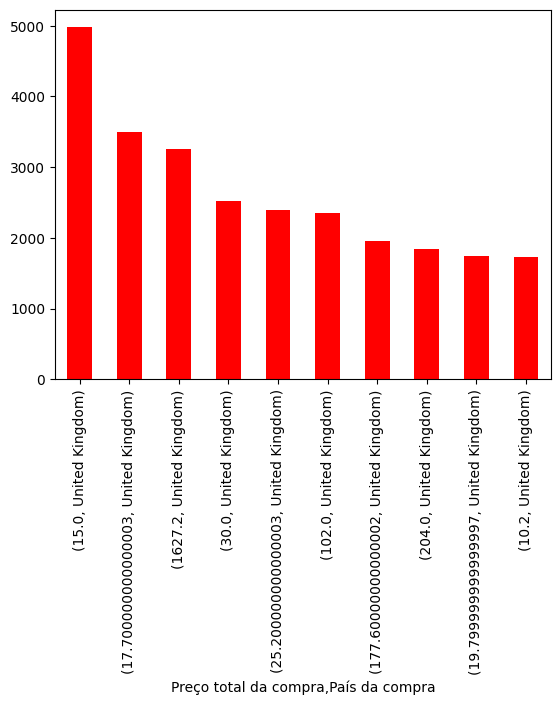

In [ ]:
#Gráfico com valor de venda total por mês e por país (Top 10)
top_paises = venda_por_pais.index
ec_top_paises = ec[ec['País da compra'].isin(top_paises)]
total_vendas_mes_paises = ec_top_paises.groupby(['Preço total da compra', 'País da compra'])['Preço total da compra'].sum().nlargest(10)
total_vendas_mes_paises.plot(kind='bar', color='red')

In [ ]:
#Calculando o RFM (R= Recência, F= Frequência e M= Ticket Médio)

data_referencia = ec['Data do faturamento (compra)'].max() + dt.timedelta(days=1)

In [ ]:
#Agrupando os dados por cliente e pedido/compra com a data e o preço total do pedido.
ec.groupby(['Código de identificação do cliente', 'Código da fatura']).agg({'Data do faturamento (compra)': 'max', 'Preço total da compra': 'sum'})

,,Data do faturamento (compra),Preço total da compra
Código de identificação do cliente,Código da fatura,,
12395.0,537026,2010-12-03 16:35:00,346.10
12427.0,536861,2010-12-03 10:44:00,303.50
12431.0,536389,2010-12-01 10:03:00,358.25
12433.0,536532,2010-12-01 13:24:00,1919.14
12472.0,537201,2010-12-05 14:19:00,1631.30
...,...,...,...
18156.0,537133,2010-12-05 12:29:00,206.23
18168.0,536836,2010-12-02 18:08:00,263.30
18219.0,537239,2010-12-06 10:05:00,210.19


In [ ]:
#Agrupando dos dados apenas por cliente.
ec.groupby('Código de identificação do cliente').agg({'Data do faturamento (compra)': 'max', 'Preço total da compra':'sum'})

,Data do faturamento (compra),Preço total da compra
Código de identificação do cliente,,
12395.0,2010-12-03 16:35:00,346.10
12427.0,2010-12-03 10:44:00,303.50
12431.0,2010-12-01 10:03:00,358.25
12433.0,2010-12-01 13:24:00,1919.14
12472.0,2010-12-05 14:19:00,1631.30
...,...,...
18156.0,2010-12-05 12:29:00,206.23
18168.0,2010-12-02 18:08:00,263.30
18219.0,2010-12-06 10:05:00,210.19


In [ ]:
#calculando a recência:
recencia_ec = ec.groupby('Código de identificação do cliente')['Data do faturamento (compra)'].max().reset_index()
recencia_ec.columns = ['Código de identificação do cliente', 'DataUltimaCompra']
recencia_ec['Recencia'] = (data_referencia - recencia_ec['DataUltimaCompra']).dt.days

In [ ]:
#calculando a frequência:
frequencia_ec = ec.groupby('Código de identificação do cliente')['Data do faturamento (compra)'].count().reset_index()
frequencia_ec.columns = ['Código de identificação do cliente', 'Frequencia']

In [ ]:
#calculando o ticket médio:
monetario_ec = ec.groupby('Código de identificação do cliente')['Preço unitário do produto'].sum().reset_index()
monetario_ec.columns = ['Código de identificação do cliente', 'Preço total da compra']

In [ ]:
rfm_ec = pd.merge(recencia_ec, frequencia_ec, on='Código de identificação do cliente')
rfm_ec = pd.merge(rfm_ec, monetario_ec, on='Código de identificação do cliente')

In [ ]:
rfm_ec['RecenciaRank'] = pd.qcut(rfm_ec['Recencia'], q=3, labels=["Baixa", "Média", "Alta"])
rfm_ec['FrequenciaRank'] = pd.qcut(rfm_ec['Frequencia'], q=3, labels=["Baixa", "Média", "Alta"])
rfm_ec['ticketmedioRank'] = pd.qcut(rfm_ec['Preço total da compra'], q=3, labels=["Baixa", "Média", "Alta"])

In [ ]:
rfm_ec.tail(10)

,Código de identificação do cliente,DataUltimaCompra,Recencia,Frequencia,Preço total da compra,RecenciaRank,FrequenciaRank,ticketmedioRank
338,18085.0,2010-12-01 12:08:00,6,9,34.60,Alta,Baixa,Média
339,18109.0,2010-12-05 10:58:00,2,14,68.40,Baixa,Média,Média
340,18113.0,2010-12-06 12:31:00,1,1,1.06,Baixa,Baixa,Baixa
341,18118.0,2010-12-05 12:13:00,2,118,300.21,Baixa,Alta,Alta
342,18144.0,2010-12-01 13:45:00,5,3,7.89,Média,Baixa,Baixa
343,18156.0,2010-12-05 12:29:00,2,55,163.99,Baixa,Alta,Alta
344,18168.0,2010-12-02 18:08:00,4,27,116.39,Média,Alta,Alta
345,18219.0,2010-12-06 10:05:00,1,13,60.48,Baixa,Média,Média
346,18229.0,2010-12-01 16:25:00,5,7,48.65,Média,Baixa,Média
347,18239.0,2010-12-02 17:48:00,4,29,96.90,Média,Alta,Alta
